# 推理与部署

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/tutorials/zh_cn/beginner/mindspore_infer.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/tutorials/zh_cn/beginner/mindspore_infer.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/tutorials/source_zh_cn/beginner/infer.ipynb)

本章使用MindSpore Vision中的`mobilenet_v2`网络微调的方法来开发一个AI应用（狗和牛角包分类），并将训练好的网络模型部署到Android手机上，执行推理和部署功能。

## 数据准备与加载

### 下载数据集

首先需要下载本案例所用到的[狗与牛角包分类数据集](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/beginner/DogCroissants.zip)，该数据集有狗和牛角包两个类别，每个类有大约150张训练图像、20张验证图像和1张推理图像。

具体数据集如下所示：

![datset-dog](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_zh_cn/beginner/images/datset_dog.png)

使用MindSpore Vision中的`DownLoad`接口下载并解压数据集到指定路径下，示例代码如下所示：

In [1]:
from mindvision.dataset import DownLoad

dataset_url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/beginner/DogCroissants.zip"
path = "./datasets"

dl = DownLoad()
# 下载并解压数据集
dl.download_and_extract_archive(dataset_url, path)

数据集的目录结构如下所示：

```text
datasets
└── DogCroissants
    ├── infer
    │   ├── croissants.jpg
    │   └── dog.jpg
    ├── train
    │   ├── croissants
    │   └── dog
    └── val
        ├── croissants
        └── dog
```

### 加载数据集

定义 `create_dataset`函数加载狗和牛角包数据集，对数据集进行图像增强操作并设置数据集batch_size大小。

In [2]:
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as transforms

def create_dataset(path, batch_size=10, train=True, image_size=224):
    dataset = ds.ImageFolderDataset(path, num_parallel_workers=8, class_indexing={"croissants": 0, "dog": 1})

    # 图像增强操作
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    if train:
        trans = [
            transforms.RandomCropDecodeResize(image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            transforms.RandomHorizontalFlip(prob=0.5),
            transforms.Normalize(mean=mean, std=std),
            transforms.HWC2CHW()
        ]
    else:
        trans = [
            transforms.Decode(),
            transforms.Resize(256),
            transforms.CenterCrop(image_size),
            transforms.Normalize(mean=mean, std=std),
            transforms.HWC2CHW()
        ]

    dataset = dataset.map(operations=trans, input_columns="image", num_parallel_workers=8)
    # 设置batch_size的大小，若最后一次抓取的样本数小于batch_size，则丢弃
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

加载训练数据集和验证数据集用于后续的模型训练和验证。

In [3]:
# 加载训练数据集
train_path = "./datasets/DogCroissants/train"
dataset_train = create_dataset(train_path, train=True)

# 加载验证数据集
val_path = "./datasets/DogCroissants/val"
dataset_val = create_dataset(val_path, train=False)

## 模型训练

本案例使用预训练模型在狗与牛角包的分类数据集上对模型进行微调，并将训练好的CKPT模型文件转换为MINDIR格式，用于后续手机侧的部署。

> 模型训练目前只支持Linux环境运行

### MobileNet V2模型原理

MobileNet网络是由Google团队于2017年提出的专注于移动端、嵌入式或IoT设备的轻量级CNN网络，相比于传统的卷积神经网络，MobileNet网络使用深度可分离卷积（Depthwise Separable Convolution）的思想在准确率小幅度降低的前提下，大大减小了模型参数与运算量。并引入宽度系数 $\alpha$ 和分辨率系数 $\beta$ 使模型满足不同应用场景的需求。

由于MobileNet网络中Relu激活函数处理低维特征信息时会存在大量的丢失，所以MobileNetV2网络提出使用倒残差结构（Inverted residual block）和Linear Bottlenecks来设计网络，以提高模型的准确率，且优化后的模型更小。

![mobilenet](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_zh_cn/beginner/images/mobilenet.png)

图中Inverted residual block结构是先使用1x1卷积进行升维，然后使用3x3的DepthWise卷积，最后使用1x1的卷积进行降维。与Residual block结构相反，Residual block是先使用1x1的卷积进行降维，然后使用3x3的卷积，最后使用1x1的卷积进行升维。

> [详细内容可参见MobileNet V2论文](https://arxiv.org/pdf/1801.04381.pdf)

### 下载预训练模型

下载案例所需的[MobileNetV2预训练模型的ckpt文件](https://download.mindspore.cn/vision/classification/mobilenet_v2_1.0_224.ckpt)，预训练模型的宽度系数$\alpha= 1.0$，输入图像大小为(224, 224), 将下载的预训练模型保存在当前目录下。使用MindSpore Vision中的`DownLoad`下载预训练模型文件到当前目录下，示例代码如下所示：

In [4]:
from mindvision.dataset import DownLoad

models_url = "https://download.mindspore.cn/vision/classification/mobilenet_v2_1.0_224.ckpt"

dl = DownLoad()
# 下载预训练模型文件
dl.download_url(models_url)

### MobileNet V2模型微调

本章使用MobileNet V2的预训练模型进行微调，通过删除MobileNet V2预训练模型中最后一个用于分类的1x1的卷积层的参数，使用狗与牛角包数据集对模型进行重新训练以更新模型参数。

In [5]:
import mindspore.nn as nn
from mindspore.train import Model
from mindspore import load_checkpoint, load_param_into_net

from mindvision.classification.models import mobilenet_v2
from mindvision.engine.loss import CrossEntropySmooth

# 创建模型,其中目标分类数为2，图像输入大小为(224,224)
network = mobilenet_v2(num_classes=2, resize=224)

# 模型参数存入到param_dict
param_dict = load_checkpoint("./mobilenet_v2_1.0_224.ckpt")

# 获取mobilenet_v2网络最后一个卷积层的参数名
filter_list = [x.name for x in network.head.classifier.get_parameters()]

# 删除预训练模型的最后一个卷积层
def filter_ckpt_parameter(origin_dict, param_filter):
    for key in list(origin_dict.keys()):
        for name in param_filter:
            if name in key:
                print("Delete parameter from checkpoint: ", key)
                del origin_dict[key]
                break

filter_ckpt_parameter(param_dict, filter_list)

# 加载预训练模型参数作为网络初始化权重
load_param_into_net(network, param_dict)

# 定义优化器
network_opt = nn.Momentum(params=network.trainable_params(), learning_rate=0.01, momentum=0.9)

# 定义损失函数
network_loss = CrossEntropySmooth(sparse=True, reduction="mean", smooth_factor=0.1, classes_num=2)

# 定义评价指标
metrics = {"Accuracy": nn.Accuracy()}

# 初始化模型
model = Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=metrics)

[WARNING] ME(375486:140361546602304,MainProcess): [mindspore/train/serialization.py:644] 2 parameters in the 'net' are not loaded, because they are not in the 'parameter_dict'.
[WARNING] ME(375486:140361546602304,MainProcess): [mindspore/train/serialization.py:646] head.classifier.weight is not loaded.
[WARNING] ME(375486:140361546602304,MainProcess): [mindspore/train/serialization.py:646] head.classifier.bias is not loaded.
Delete parameter from checkpoint:  head.classifier.weight
Delete parameter from checkpoint:  head.classifier.bias
Delete parameter from checkpoint:  moments.head.classifier.weight
Delete parameter from checkpoint:  moments.head.classifier.bias


> 上述WARNING是由于模型微调需要删除预训练模型的最后一个卷积层的参数，所以加载预训练模型会显示`head.classifier`参数未加载，`head.classifier`参数会使用创建模型时的初始化值。

### 模型训练与评估

训练并评估网络，使用MindSpore Vision中的`mindvision.engine.callback.ValAccMonitor`接口打印训练的损失值和评估精度，且在训练完成后，保存评估精度最高的CKPT文件`best.ckpt`在当前目录下。

In [6]:
from mindvision.engine.callback import ValAccMonitor
from mindspore.train.callback import TimeMonitor

num_epochs = 10

# 模型训练与验证，训练完成后保存验证精度最高的ckpt文件（best.ckpt）到当前目录下
model.train(num_epochs,
            dataset_train,
            callbacks=[ValAccMonitor(model, dataset_val, num_epochs), TimeMonitor()])

--------------------
Epoch: [  1 /  10], Train Loss: [0.388], Accuracy:  0.975
epoch time: 7390.423 ms, per step time: 254.842 ms
--------------------
Epoch: [  2 /  10], Train Loss: [0.378], Accuracy:  0.975
epoch time: 1876.590 ms, per step time: 64.710 ms
--------------------
Epoch: [  3 /  10], Train Loss: [0.372], Accuracy:  1.000
epoch time: 2103.431 ms, per step time: 72.532 ms
--------------------
Epoch: [  4 /  10], Train Loss: [0.346], Accuracy:  1.000
epoch time: 2246.303 ms, per step time: 77.459 ms
--------------------
Epoch: [  5 /  10], Train Loss: [0.376], Accuracy:  1.000
epoch time: 2164.527 ms, per step time: 74.639 ms
--------------------
Epoch: [  6 /  10], Train Loss: [0.353], Accuracy:  1.000
epoch time: 2191.490 ms, per step time: 75.569 ms
--------------------
Epoch: [  7 /  10], Train Loss: [0.414], Accuracy:  1.000
epoch time: 2183.388 ms, per step time: 75.289 ms
--------------------
Epoch: [  8 /  10], Train Loss: [0.362], Accuracy:  1.000
epoch time: 2219.

### 可视化模型预测

定义 `visualize_model` 函数，使用上述验证精度最高的模型对输入图像进行预测，并将预测结果可视化。

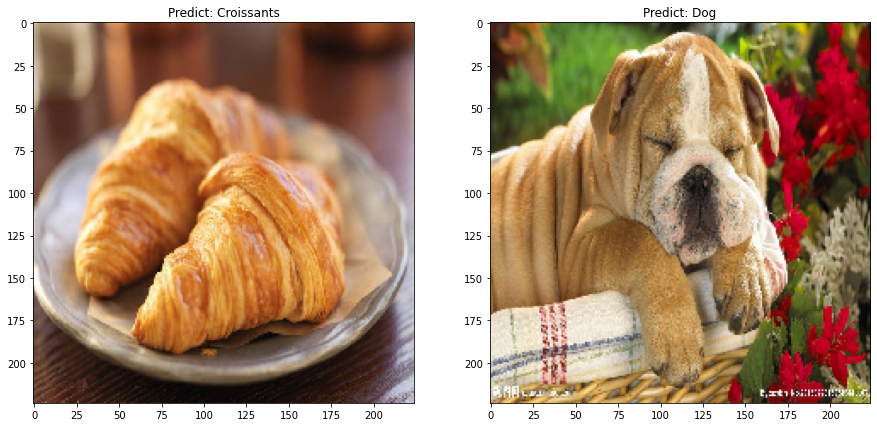

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from mindspore import Tensor

def visualize_model(path):
    image = Image.open(path).convert("RGB")
    image = image.resize((224, 224))
    plt.imshow(image)

    # 归一化处理
    mean = np.array([0.485 * 255, 0.456 * 255, 0.406 * 255])
    std = np.array([0.229 * 255, 0.224 * 255, 0.225 * 255])
    image = np.array(image)
    image = (image - mean) / std
    image = image.astype(np.float32)

    # 图像通道由(h, w, c)转换为(c, h, w)
    image = np.transpose(image, (2, 0, 1))

    # 扩展数据维数为(1，c, h, w)
    image = np.expand_dims(image, axis=0)

    # 定义并加载网络
    net = mobilenet_v2(num_classes=2, resize=224)
    param_dict = load_checkpoint("./best.ckpt")
    load_param_into_net(net, param_dict)
    model = Model(net)

    # 模型预测
    pre = model.predict(Tensor(image))
    result = np.argmax(pre)

    class_name = {0: "Croissants", 1: "Dog"}
    plt.title(f"Predict: {class_name[result]}")
    return result

image1 = "./datasets/DogCroissants/infer/croissants.jpg"
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
visualize_model(image1)

image2 = "./datasets/DogCroissants/infer/dog.jpg"
plt.subplot(1, 2, 2)
visualize_model(image2)

plt.show()

### 模型导出

在模型训练完后，训练完成后的网络模型（即CKPT文件）转换为MindIR格式，用于后续手机侧的推理。通过`export`接口会在当前目录下会生成`mobilenet_v2_1.0_224.mindir`文件。

In [9]:
from mindspore import export, Tensor

# 定义并加载网络参数
net = mobilenet_v2(num_classes=2, resize=224)
param_dict = load_checkpoint("best.ckpt")
load_param_into_net(net, param_dict)

# 将模型由ckpt格式导出为MINDIR格式
input_np = np.random.uniform(0.0, 1.0, size=[1, 3, 224, 224]).astype(np.float32)
export(net, Tensor(input_np), file_name="mobilenet_v2_1.0_224", file_format="MINDIR")

## 手机侧推理与部署

为实现模型文件在手机侧的推理功能，步骤如下：

- 转换文件格式：将MindIR文件格式，转换成Android手机上MindSpore Lite可识别文件；
- 应用部署：在手机侧部署应用APK，即下载一个MindSpore Vision套件Android APK；
- 应用体验：最后将ms模型文件导入到手机侧后，体验狗与牛角包的识别功能。

### 转换文件格式

使用端侧应用的转换工具[MindSpore Lite Converter](https://www.mindspore.cn/lite/docs/zh-CN/master/use/converter_tool.html)，将训练过程当中生成的mobilenet_v2_1.0_224.mindir文件，转换为MindSpore Lite端侧推理框架可识别的文件格式mobilenet_v2_1.0_224.ms文件。

具体的模型文件格式转换方式如下所示：

1. Linux下使用MindSpore Lite Converter转换文件格式，[Linux-x86_64工具下载链接](https://www.mindspore.cn/lite/docs/zh-CN/master/use/downloads.html)。

```shell
# 下载解压后设置软件包的路径，{converter_path}为解压后工具包的路径，PACKAGE_ROOT_PATH为设置的环境变量
export PACKAGE_ROOT_PATH={converter_path}

# 将转换工具需要的动态链接库加入到环境变量LD_LIBRARY_PATH
export LD_LIBRARY_PATH=${PACKAGE_ROOT_PATH}/tools/converter/lib:${LD_LIBRARY_PATH}

# 在mindspore-lite-linux-x64/tools/converter/converter执行转换命令
./converter_lite --fmk=MINDIR --modelFile=mobilenet_v2_1.0_224.mindir  --outputFile=mobilenet_v2_1.0_224
```

2. Windows下使用MindSpore Lite Converter转换文件格式，[Windows-x64工具下载链接](https://www.mindspore.cn/lite/docs/zh-CN/master/use/downloads.html)。

```shell
# 下载解压后设置软件包的路径，{converter_path}为解压后工具包的路径，PACKAGE_ROOT_PATH为设置的环境变量
set PACKAGE_ROOT_PATH={converter_path}

# 将转换工具需要的动态链接库加入到环境变量PATH
set PATH=%PACKAGE_ROOT_PATH%\tools\converter\lib;%PATH%

# 在mindspore-lite-win-x64\tools\converter\converter路径下执行转换命令
call converter_lite --fmk=MINDIR --modelFile=mobilenet_v2_1.0_224.mindir --outputFile=mobilenet_v2_1.0_224
```

转换成功后打印`CONVERT RESULT SUCCESS:0`，且在当前目录下生成`mobilenet_v2_1.0_224.ms`文件。

> 其他环境下载MindSpore Lite Converter参见[下载MindSpore Lite](https://www.mindspore.cn/lite/docs/zh-CN/master/use/downloads.html)。

### 应用部署

下载MindSpore Vision套件的[Android端应用APK](https://gitee.com/mindspore/vision/releases/)，并在手机上安装该APK，其应用名称显示为`MindSpore Vision`。

> MindSpore Vision APK主要是作为视觉开发工具的示例所用，提供拍照、选择图片等基础UI功能，并且提供分类、检测、人脸识别等AI应用DEMO。

打开APP后，在首页点击`分类`模块后，即可点击中间按钮进行拍照获取图片，或者点击上侧栏的图像按钮选择进行图片相册用于图像分类功能。

![main](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_zh_cn/beginner/images/app1.png)

在默认情况下，MindSpore Vision`分类`模块内置了一个通用的AI网络模型对图像进行识别分类。

![result](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_zh_cn/beginner/images/app2.png)

### 应用体验

最后将上述训练的自定义网络模型mobilenet_v2_1.0_224.ms部署到Android手机侧，体验狗与牛角包的识别功能。

#### 自定义模型标签文件

自定义模型部署需要按照如下格式定义网络模型需要用到的信息，即自定义标签文件，并在本地电脑端侧创建一个必须以`custom.json`命名的json格式标签文件。

```text
{
    "title": '狗和牛角包',
    "file": 'mobilenet_v2_1.0_224.ms',
    "label": ['牛角包', '狗']
}
```

Json标签文件中需包含`title`，`file`，`label`三个Key值字段，其含义如下：

- title ：自定义模块标题(狗和牛角包)；
- file ：上文转换好的模型文件名称；
- label ：自定义标签label的`数组`信息。

#### 标签与模型文件部署到手机

在`MindSpore Vision APK`的首页上长按`分类`按钮，可以进入自定义分类模式，并且选择需要部署的标签和模型文件。

为实现手机端狗与牛角包的识别功能，需将标签文件`custom.json`文件和模型文件`mobilenet_v2_1.0_224.ms`一起放置到手机上指定目录下。这里以`Android/data/Download/` 文件夹为例，首先把标签文件和模型文件同时放在上述手机地址，如图所示，点击自定义按钮，然后会弹出系统文件功能，点击左上角的打开文件，然后找到Json标签文件和模型文件存放的目录地址，并选择对应的Json文件。

![step](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_zh_cn/beginner/images/app3.png)

标签与模型文件部署到手机后，即可点击中间按钮进行拍照获取图片，或者点击上侧栏的图像按钮选择图片相册用于图像，就可以进行狗与牛角包的分类识别。

![result1](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_zh_cn/beginner/images/app4.png)



> 本章仅包含手机侧简单的部署过程，想要了解推理更多内容请参考[MindSpore Lite](https://www.mindspore.cn/lite/docs/zh-CN/master/index.html)。
